<a href="https://colab.research.google.com/github/finesaaa/clustering-assignment/blob/main/hierarchical_clustering_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 

%matplotlib inline

In [2]:
dataset = pd.read_csv("travel insurance.csv", nrows = 10000)
dataset.head() 

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [3]:
dataset.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Gender', 'Age'],
      dtype='object')

In [4]:
dataset.rename(columns={ 'Agency Type':'Agency_Type', 'Distribution Channel':'Distribution_Channel', 'Product Name':'Product_Name','Net Sales':'Net_Sales', 'Commision (in value)':'Commision'},inplace=True)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                10000 non-null  object 
 1   Agency_Type           10000 non-null  object 
 2   Distribution_Channel  10000 non-null  object 
 3   Product_Name          10000 non-null  object 
 4   Claim                 10000 non-null  object 
 5   Duration              10000 non-null  int64  
 6   Destination           10000 non-null  object 
 7   Net_Sales             10000 non-null  float64
 8   Commision             10000 non-null  float64
 9   Gender                2084 non-null   object 
 10  Age                   10000 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 859.5+ KB


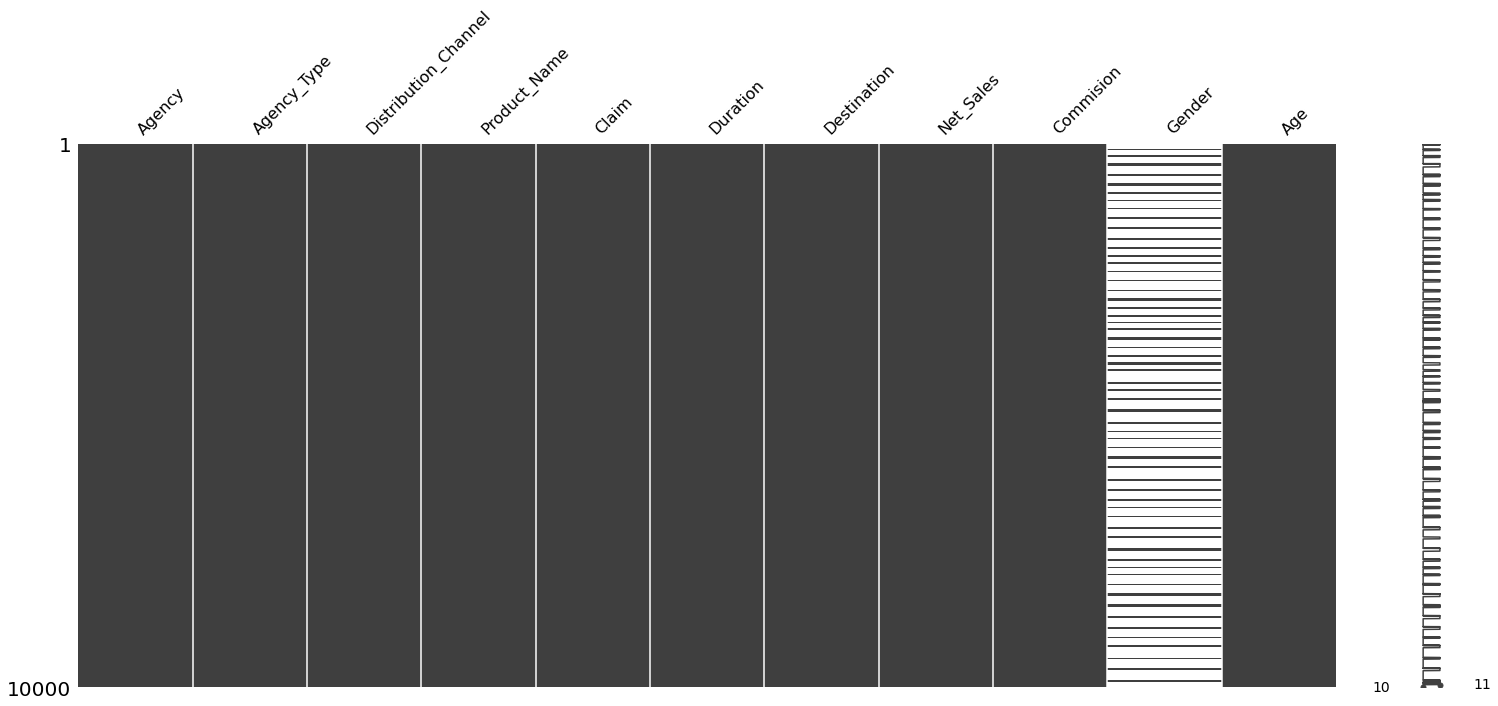

In [6]:
import missingno
missingno.matrix(dataset)

In [7]:
dataset=dataset.drop(['Gender'], axis=1)
dataset.head()

,Agency,Agency_Type,Distribution_Channel,Product_Name,Claim,Duration,Destination,Net_Sales,Commision,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,41


In [8]:
column_keys=dataset.select_dtypes(include=['object']).columns.tolist()
for key in column_keys:
    print('Unique elements of',key,'are: ')
    print(dataset[key].unique(),end='\n')
    print(end='\n')

Unique elements of Agency are: 
['CBH' 'CWT' 'JZI' 'KML' 'EPX' 'C2B' 'JWT' 'RAB' 'SSI' 'ART' 'CSR' 'CCR'
 'ADM']

Unique elements of Agency_Type are: 
['Travel Agency' 'Airlines']

Unique elements of Distribution_Channel are: 
['Offline' 'Online']

Unique elements of Product_Name are: 
['Comprehensive Plan' 'Rental Vehicle Excess Insurance' 'Value Plan'
 'Basic Plan' 'Premier Plan' '2 way Comprehensive Plan' 'Bronze Plan'
 'Silver Plan' 'Annual Silver Plan' 'Cancellation Plan'
 '1 way Comprehensive Plan' 'Ticket Protector' '24 Protect' 'Gold Plan'
 'Annual Gold Plan']

Unique elements of Claim are: 
['No' 'Yes']

Unique elements of Destination are: 
['MALAYSIA' 'AUSTRALIA' 'ITALY' 'UNITED STATES' 'THAILAND'
 "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF" 'NORWAY' 'VIET NAM' 'DENMARK'
 'SINGAPORE' 'JAPAN' 'UNITED KINGDOM' 'INDONESIA' 'INDIA' 'CHINA' 'FRANCE'
 'TAIWAN, PROVINCE OF CHINA' 'PHILIPPINES' 'MYANMAR' 'HONG KONG'
 'KOREA, REPUBLIC OF' 'UNITED ARAB EMIRATES' 'NAMIBIA' 'NEW ZEALAND'
 '

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
dataset['Agency_Type']= label_encoder.fit_transform(dataset['Agency_Type'])

dataset

,Agency,Agency_Type,Distribution_Channel,Product_Name,Claim,Duration,Destination,Net_Sales,Commision,Age
0,CBH,1,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,81
1,CBH,1,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,71
2,CWT,1,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,32
3,CWT,1,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,32
4,CWT,1,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,41
...,...,...,...,...,...,...,...,...,...,...
9995,EPX,1,Online,2 way Comprehensive Plan,No,97,SPAIN,54.0,0.00,36
9996,EPX,1,Online,2 way Comprehensive Plan,No,60,INDONESIA,20.0,0.00,36
9997,EPX,1,Online,2 way Comprehensive Plan,No,89,CHINA,40.0,0.00,36
9998,EPX,1,Online,2 way Comprehensive Plan,No,38,AUSTRALIA,58.0,0.00,36


In [10]:
selected_dataset = dataset[['Agency_Type','Duration','Net_Sales', 'Commision', 'Age']]
selected_dataset = pd.DataFrame(selected_dataset, columns=['Agency_Type','Duration','Net_Sales', 'Commision', 'Age'])
selected_dataset

,Agency_Type,Duration,Net_Sales,Commision,Age
0,1,186,-29.0,9.57,81
1,1,186,-29.0,9.57,71
2,1,65,-49.5,29.70,32
3,1,60,-39.6,23.76,32
4,1,79,-19.8,11.88,41
...,...,...,...,...,...
9995,1,97,54.0,0.00,36
9996,1,60,20.0,0.00,36
9997,1,89,40.0,0.00,36
9998,1,38,58.0,0.00,36


## Remove Outliers

In [11]:
# Removing the outliers
def removeOutliers(data, col):
	Q3 = np.quantile(data[col], 0.75)
	Q1 = np.quantile(data[col], 0.25)
	IQR = Q3 - Q1
	
	print("IQR value for column %s is: %s" % (col, IQR))
	global outlier_free_list
	global filtered_data
	
	lower_range = Q1 - 1.0 * IQR
	upper_range = Q3 + 1.0 * IQR
	outlier_free_list = [x for x in data[col] if (
		(x > lower_range) & (x < upper_range))]
	filtered_data = data.loc[data[col].isin(outlier_free_list)]


for i in selected_dataset.columns:
	removeOutliers(selected_dataset, i)

# Assigning filtered data back to our original variable
cleaned_dataset = filtered_data
print("Shape of data after outlier removal is: ", cleaned_dataset.shape)

IQR value for column Agency_Type is: 0.0
IQR value for column Duration is: 44.0
IQR value for column Net_Sales is: 25.0
IQR value for column Commision is: 7.7
IQR value for column Age is: 6.0
Shape of data after outlier removal is:  (6902, 5)


In [12]:
cleaned_dataset #after remove outliers

,Agency_Type,Duration,Net_Sales,Commision,Age
2,1,65,-49.5,29.70,32
3,1,60,-39.6,23.76,32
4,1,79,-19.8,11.88,41
5,0,66,-121.0,42.35,44
6,1,47,-39.6,23.76,32
...,...,...,...,...,...
9994,1,9,20.0,0.00,36
9995,1,97,54.0,0.00,36
9996,1,60,20.0,0.00,36
9997,1,89,40.0,0.00,36


In [13]:
from sklearn.preprocessing import MinMaxScaler
normalized_dataset = MinMaxScaler().fit_transform(np.nan_to_num(cleaned_dataset))
normalized_dataset = pd.DataFrame(normalized_dataset, columns=cleaned_dataset.columns)
normalized_dataset

,Agency_Type,Duration,Net_Sales,Commision,Age
0,1.0,0.150812,0.266217,0.185185,0.0625
1,1.0,0.139211,0.279178,0.148148,0.0625
2,1.0,0.183295,0.305099,0.074074,0.6250
3,0.0,0.153132,0.172612,0.264060,0.8125
4,1.0,0.109049,0.279178,0.148148,0.0625
...,...,...,...,...,...
6897,1.0,0.020882,0.357204,0.000000,0.3125
6898,1.0,0.225058,0.401715,0.000000,0.3125
6899,1.0,0.139211,0.357204,0.000000,0.3125
6900,1.0,0.206497,0.383387,0.000000,0.3125


## Silhouette

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0,n_components=3, verbose=1, perplexity=40)
tsne_results = tsne.fit_transform(normalized_dataset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6902 samples in 0.041s...
[t-SNE] Computed neighbors for 6902 samples in 0.660s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6902
[t-SNE] Computed conditional probabilities for sample 2000 / 6902
[t-SNE] Computed conditional probabilities for sample 3000 / 6902
[t-SNE] Computed conditional probabilities for sample 4000 / 6902
[t-SNE] Computed conditional probabilities for sample 5000 / 6902
[t-SNE] Computed conditional probabilities for sample 6000 / 6902
[t-SNE] Computed conditional probabilities for sample 6902 / 6902
[t-SNE] Mean sigma: 0.003489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.450165
[t-SNE] KL divergence after 1000 iterations: 0.447081


In [15]:
tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])

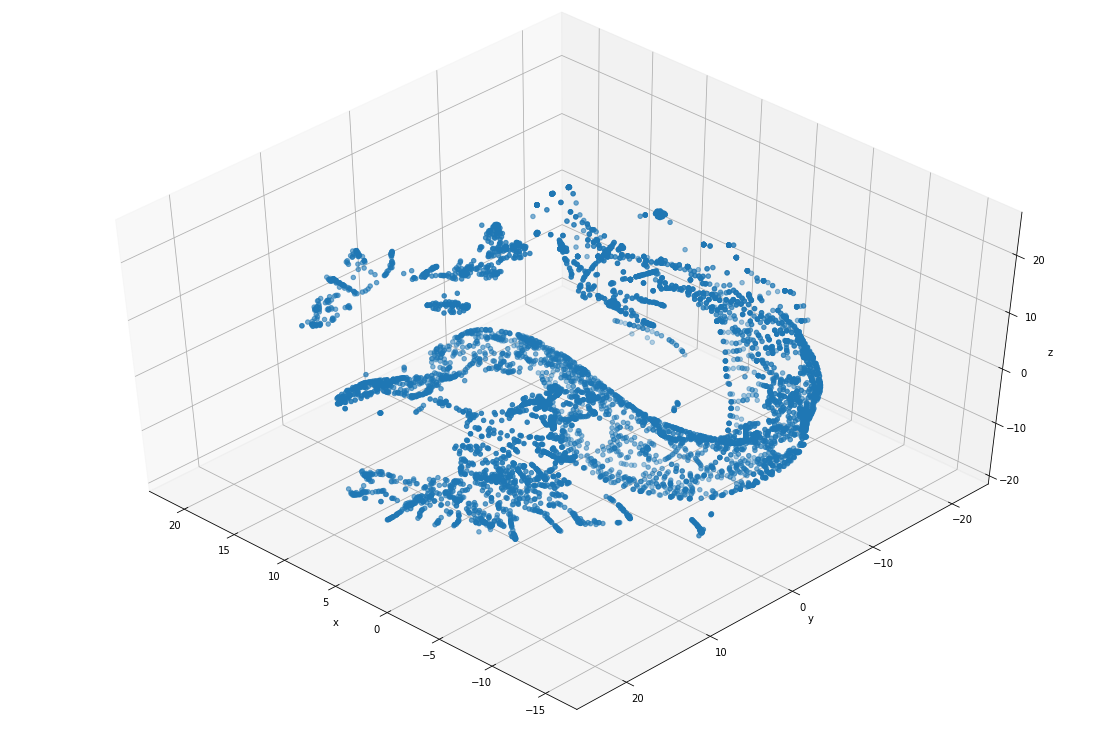

In [16]:
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(1, figsize=(16, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(tsne_results['tsne1'], tsne_results['tsne2'], tsne_results['tsne3'])

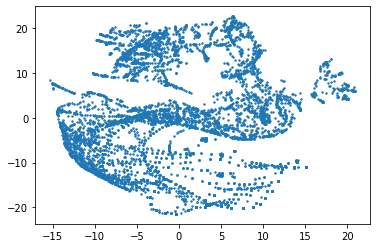

In [17]:
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], s=2)
plt.show()

In [18]:
dist_matrix = distance_matrix(normalized_dataset,normalized_dataset) 
print(dist_matrix)

[[0.         0.04091824 0.57560304 ... 0.32435577 0.33708015 0.34716586]
 [0.04091824 0.         0.56965647 ... 0.30089184 0.3159663  0.32152684]
 [0.57560304 0.56965647 0.         ... 0.32833131 0.33137667 0.35009485]
 ...
 [0.32435577 0.30089184 0.32833131 ... 0.         0.07220028 0.07127665]
 [0.33708015 0.3159663  0.33137667 ... 0.07220028 0.         0.12065307]
 [0.34716586 0.32152684 0.35009485 ... 0.07127665 0.12065307 0.        ]]


## Silhouette

In [19]:
# Silhouette Analysis Average
from sklearn.metrics import silhouette_score
N = range(2, 10)
 
for n in N:
    # Building and fitting the model
    agglom_average_model = AgglomerativeClustering(n_clusters = n, linkage = 'average')
    agglom_average_model.fit(normalized_dataset)
    cluster_labels = agglom_average_model.labels_

    # Silhouette Score
    silhouette_avg = silhouette_score(normalized_dataset, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

For n_clusters=2, the silhouette score is 0.758098828129167
For n_clusters=3, the silhouette score is 0.7583476192371913
For n_clusters=4, the silhouette score is 0.7417181860606785
For n_clusters=5, the silhouette score is 0.6822256491041694
For n_clusters=6, the silhouette score is 0.679126961922512
For n_clusters=7, the silhouette score is 0.6590399497594137
For n_clusters=8, the silhouette score is 0.6340387744421687
For n_clusters=9, the silhouette score is 0.6199471180851338


In [20]:
# Silhouette Analysis Single
from sklearn.metrics import silhouette_score
N = range(2, 10)
 
for n in N:
    # Building and fitting the model
    agglom_single_model = AgglomerativeClustering(n_clusters = n, linkage = 'single')
    agglom_single_model.fit(normalized_dataset)
    cluster_labels = agglom_single_model.labels_

    # Silhouette Score
    silhouette_avg = silhouette_score(normalized_dataset, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

For n_clusters=2, the silhouette score is 0.758098828129167
For n_clusters=3, the silhouette score is 0.7493415284547754
For n_clusters=4, the silhouette score is 0.729214831910126
For n_clusters=5, the silhouette score is 0.7385380934673422
For n_clusters=6, the silhouette score is 0.6898879053416043
For n_clusters=7, the silhouette score is 0.6838913142732967
For n_clusters=8, the silhouette score is 0.678979251224567
For n_clusters=9, the silhouette score is 0.639794805937431


In [21]:
# Silhouette Analysis Complete
from sklearn.metrics import silhouette_score
N = range(2, 10)
 
for n in N:
    # Building and fitting the model
    agglom_complete_model = AgglomerativeClustering(n_clusters = n, linkage = 'complete')
    agglom_complete_model.fit(normalized_dataset)
    cluster_labels = agglom_complete_model.labels_

    # Silhouette Score
    silhouette_avg = silhouette_score(normalized_dataset, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

For n_clusters=2, the silhouette score is 0.758098828129167
For n_clusters=3, the silhouette score is 0.7580111211509241
For n_clusters=4, the silhouette score is 0.6596103754438392
For n_clusters=5, the silhouette score is 0.5860215787453184
For n_clusters=6, the silhouette score is 0.5825343603878598
For n_clusters=7, the silhouette score is 0.5769517524262774
For n_clusters=8, the silhouette score is 0.570837738215471
For n_clusters=9, the silhouette score is 0.5648015880364462


## Aggomerative Average


In [22]:
from sklearn.cluster import AgglomerativeClustering 
agglom_average = AgglomerativeClustering(n_clusters = 3, linkage = 'average')
agglom_average.fit(normalized_dataset)
agglom_average_labels = agglom_average.labels_

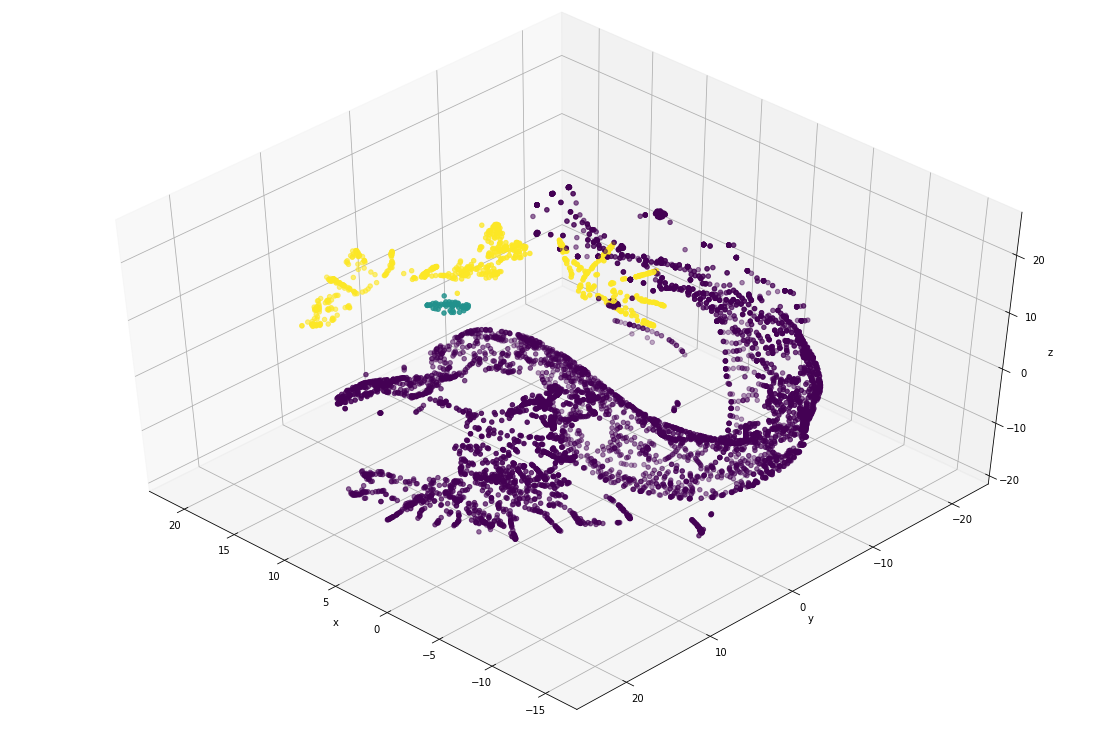

In [23]:
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(1, figsize=(16, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(tsne_results['tsne1'], tsne_results['tsne2'], tsne_results['tsne3'], c= agglom_average_labels.astype(np.float))

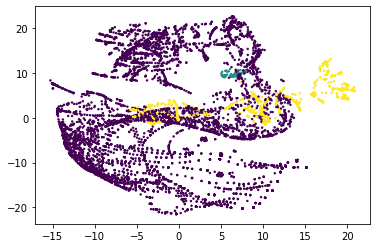

In [24]:
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], s=2, c= agglom_average_labels.astype(np.float))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


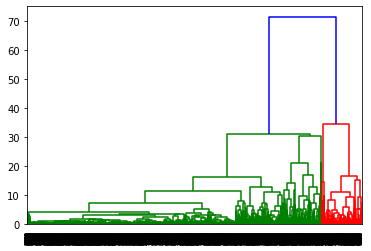

In [25]:
Z_average = hierarchy.linkage(dist_matrix, 'average')
dendro_single = hierarchy.dendrogram(Z_average)

## Aggomerative Single


In [26]:
from sklearn.cluster import AgglomerativeClustering 
agglom_single = AgglomerativeClustering(n_clusters = 2, linkage = 'single')
agglom_single.fit(normalized_dataset)
agglom_single_labels = agglom_single.labels_

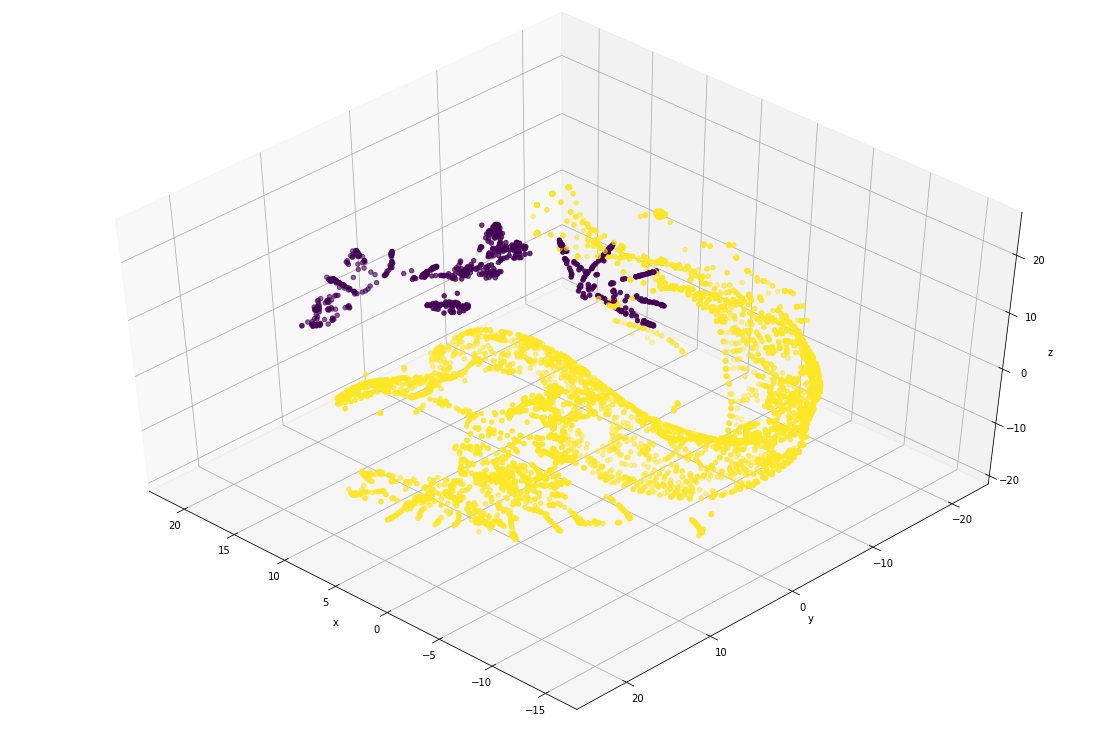

In [27]:
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(1, figsize=(16, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(tsne_results['tsne1'], tsne_results['tsne2'], tsne_results['tsne3'], c= agglom_single_labels.astype(np.float))

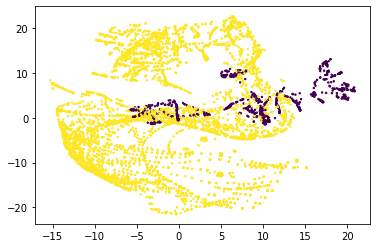

In [28]:
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], s=2, c= agglom_single_labels.astype(np.float))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


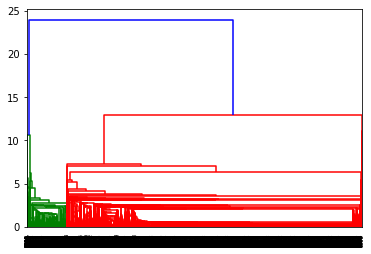

In [29]:
import sys
sys.setrecursionlimit(100000)
Z_single = hierarchy.linkage(dist_matrix, 'single')
dendro_single = hierarchy.dendrogram(Z_single)

## Aggomerative Complete


In [30]:
from sklearn.cluster import AgglomerativeClustering 
agglom_complete = AgglomerativeClustering(n_clusters = 2, linkage = 'complete')
agglom_complete.fit(normalized_dataset)
agglom_complete_labels = agglom_complete.labels_

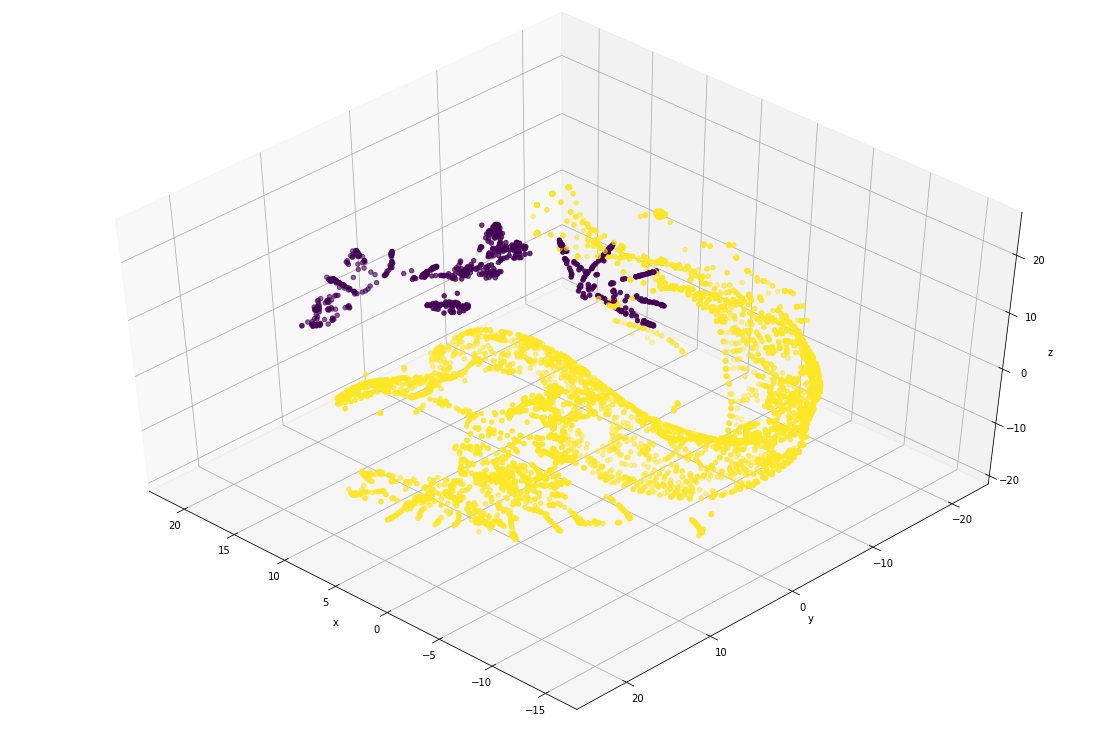

In [31]:
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(1, figsize=(16, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(tsne_results['tsne1'], tsne_results['tsne2'], tsne_results['tsne3'], c= agglom_complete_labels.astype(np.float))

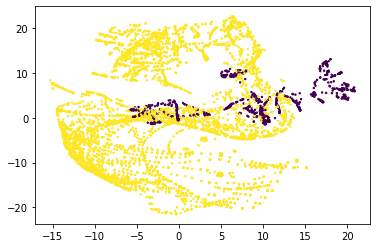

In [32]:
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], s=2, c= agglom_complete_labels.astype(np.float))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


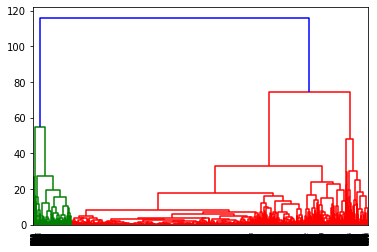

In [33]:
Z_complete = hierarchy.linkage(dist_matrix, 'complete')
dendro_complete = hierarchy.dendrogram(Z_complete)